In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from memote import ReportConfiguration
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

In [3]:
%matplotlib inline

## Extract

In [4]:
bucket = []
for filename, collection in [
    ("../data/bigg.csv.gz", "bigg"),
    ("../data/uminho.csv.gz", "uminho"),
    ("../data/mmodel.csv.gz", "ebrahim"),
    ("../data/agora.csv.gz", "agora"),
    ("../data/embl_gems.csv.gz", "embl"),
    ("../data/path2models.csv.gz", "path"),
    ("../data/seed.csv.gz", "seed"),
]:
    tmp = pd.read_csv(filename)
    tmp["collection"] = collection
    bucket.append(tmp)
df = pd.concat(bucket, ignore_index=True)

In [5]:
df.shape

(1355428, 7)

In [6]:
df.head()

,test,title,section,metric,numeric,model,collection
0,test_absolute_extreme_coefficient_ratio,Ratio Min/Max Non-Zero Coefficients,matrix,0.0,NaN,iE2348C_1286,bigg
1,test_biomass_consistency,Biomass Consistency,test_biomass,0.0,0.9996577560637441,iE2348C_1286,bigg
2,test_biomass_consistency,Biomass Consistency,test_biomass,0.0,0.999994493722013,iE2348C_1286,bigg
3,test_biomass_default_production,Biomass Production In Default Medium,test_biomass,1.0,-1.717385045787279e-17,iE2348C_1286,bigg
4,test_biomass_default_production,Biomass Production In Default Medium,test_biomass,0.0,0.9824784386660113,iE2348C_1286,bigg


## Transform

In [7]:
df = df.loc[df["metric"].notnull(), :]

Exclude the biomass section since it is not universal as well as the matrix section since that is purely informative and says nothing about the model quality.

In [8]:
df = df.loc[~df["section"].isin([
    "matrix",
    "test_biomass"
]), :]

Exclude some further individual tests.

In [9]:
df = df.loc[~df["test"].isin([
    "test_biomass_open_production",
    "test_metabolic_coverage",
    "test_essential_precursors_not_in_biomass",
    "test_find_duplicate_reactions",
    "test_gam_in_biomass"
]), :]

In [10]:
df["collection"].unique()

array(['bigg', 'uminho', 'ebrahim', 'agora', 'embl', 'path', 'seed'],
      dtype=object)

### Pivot Table

In [11]:
df.set_index(["collection", "model", "test"], inplace=True)

In [12]:
df[df.index.duplicated(keep=False)].sort_index()

,,,title,section,metric,numeric
collection,model,test,,,,


In [13]:
observations = df.loc[:, ["metric"]].unstack()
observations.head()

metric  \
test                                             test_biomass_specific_sbo_presence   
collection model                                                                      
agora      Abiotrophia_defectiva_ATCC_49176                                     1.0   
           Achromobacter_xylosoxidans_A8                                        1.0   
           Achromobacter_xylosoxidans_NBRC_15126                                1.0   
           Acidaminococcus_fermentans_DSM_20731                                 1.0   
           Acidaminococcus_intestini_RyC_MR95                                   1.0   

                                                                         \
test                                             test_blocked_reactions   
collection model                                                          
agora      Abiotrophia_defectiva_ATCC_49176                    0.279701   
           Achromobacter_xylosoxidans_A8                       0.366250   
           Achromobacter_xylosoxidans_NBRC_15126               0.293694   
           Acidaminococcus_fermentans_DSM_20731                0.348944   
           Acidaminococcus_intestini_RyC_MR95                  0.305835   

                                                                             \
test                                             test_compartments_presence   
collection model                                                              
agora      Abiotrophia_defectiva_ATCC_49176                             0.0   
           Achromobacter_xylosoxidans_A8                                0.0   
           Achromobacter_xylosoxidans_NBRC_15126                        0.0   
           Acidaminococcus_fermentans_DSM_20731                         0.0   
           Acidaminococcus_intestini_RyC_MR95                           0.0   

                                                                                    \
test                                             test_demand_specific_sbo_presence   
collection model                                                                     
agora      Abiotrophia_defectiva_ATCC_49176                                    1.0   
           Achromobacter_xylosoxidans_A8                                       1.0   
           Achromobacter_xylosoxidans_NBRC_15126                               1.0   
           Acidaminococcus_fermentans_DSM_20731                                1.0   
           Acidaminococcus_intestini_RyC_MR95                                  1.0   

                                                                                      \
test                                             test_exchange_specific_sbo_presence   
collection model                                                                       
agora      Abiotrophia_defectiva_ATCC_49176                                      1.0   
           Achromobacter_xylosoxidans_A8                                         1.0   
           Achromobacter_xylosoxidans_NBRC_15126                                 1.0   
           Acidaminococcus_fermentans_DSM_20731                                  1.0   
           Acidaminococcus_intestini_RyC_MR95                                    1.0   

                                                                    \
test                                             test_fbc_presence   
collection model                                                     
agora      Abiotrophia_defectiva_ATCC_49176                    0.0   
           Achromobacter_xylosoxidans_A8                       0.0   
           Achromobacter_xylosoxidans_NBRC_15126               0.0   
           Acidaminococcus_fermentans_DSM_20731                0.0   
           Acidaminococcus_intestini_RyC_MR95                  0.0   

                                                                                             \
test                                             test_find_candidate_irreversible_reactions   
c

In [14]:
observations.shape

(10647, 111)

In [15]:
observations.index.get_level_values("collection").unique()

Index(['agora', 'bigg', 'ebrahim', 'embl', 'path', 'seed', 'uminho'], dtype='object', name='collection')

In [16]:
observations.isna().sum(axis=0).sort_values(ascending=False)

        test                                                  
metric  test_gene_product_annotation_overview-ncbigene            57
        test_gene_product_annotation_overview-asap                57
        test_gene_product_annotation_overview-ecogene             57
        test_gene_product_annotation_overview-hprd                57
        test_gene_product_annotation_overview-kegg.genes          57
        test_gene_product_annotation_overview-ncbigi              57
        test_gene_product_annotation_overview-ncbiprotein         57
        test_gene_product_annotation_overview-refseq              57
        test_gene_product_annotation_overview-uniprot             57
        test_gene_product_annotation_overview-ccds                57
        test_metabolite_annotation_overview-reactome               1
        test_metabolite_annotation_overview-pubchem.compound       1
        test_metabolite_annotation_overview-metanetx.chemical      1
        test_metabolite_annotation_overv

Ignore problematic test cases and models for now.

In [17]:
clean = observations.dropna(axis=1)

In [18]:
clean.shape

(10647, 90)

In [19]:
clean.index.get_level_values("collection").unique()

Index(['agora', 'bigg', 'ebrahim', 'embl', 'path', 'seed', 'uminho'], dtype='object', name='collection')

## Dimension Reduction

In [20]:
plt.rcParams['figure.figsize'] = 16, 9

In [21]:
colors = [
  "#A6A9AA",
  "#000000",
  "#3E7CBC",
  "#A3D2E2",
  "#DDEDF6",
  "#EDA85F",
  "#CD2028"
]

### PCA

In [22]:
%%time
pca = PCA(n_components=2).fit_transform(clean)

CPU times: user 293 ms, sys: 101 ms, total: 394 ms
Wall time: 59.7 ms


In [23]:
x = []
y = []
lbl = []
for label in clean.index.get_level_values("collection").unique():
    mask = clean.index.get_level_values("collection") == label
    x.extend(pca[mask, 0])
    y.extend(pca[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("../data/metric_pca.csv.gz", index=False)

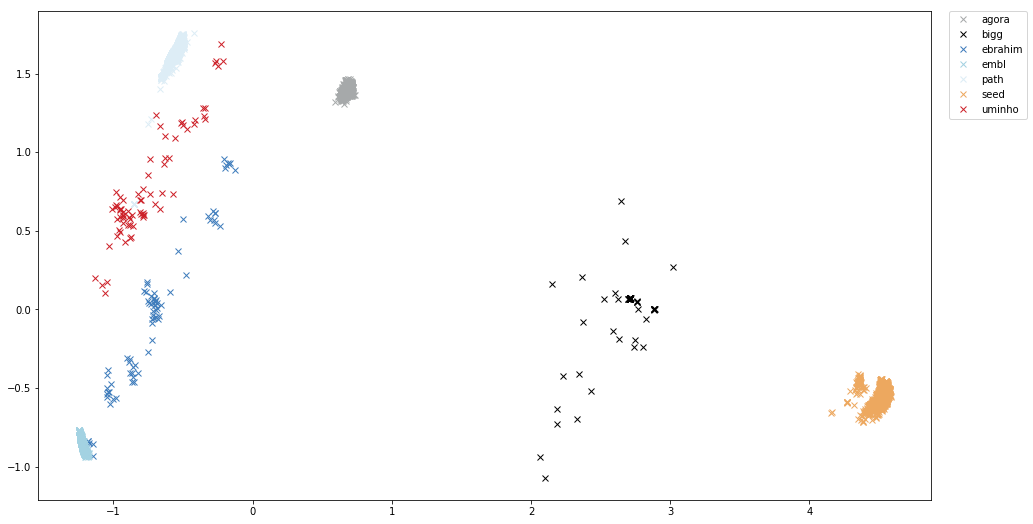

In [24]:
for label, color in zip(clean.index.get_level_values("collection").unique(), colors):
    mask = clean.index.get_level_values("collection") == label
    plt.plot(pca[mask, 0], pca[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()

### t-SNE

In [25]:
%%time
tsne = TSNE(n_components=2).fit_transform(clean)

CPU times: user 1min 7s, sys: 5.45 ms, total: 1min 7s
Wall time: 1min 7s


In [26]:
x = []
y = []
lbl = []
for label in clean.index.get_level_values("collection").unique():
    mask = clean.index.get_level_values("collection") == label
    x.extend(tsne[mask, 0])
    y.extend(tsne[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("../data/metric_tsne.csv.gz", index=False)

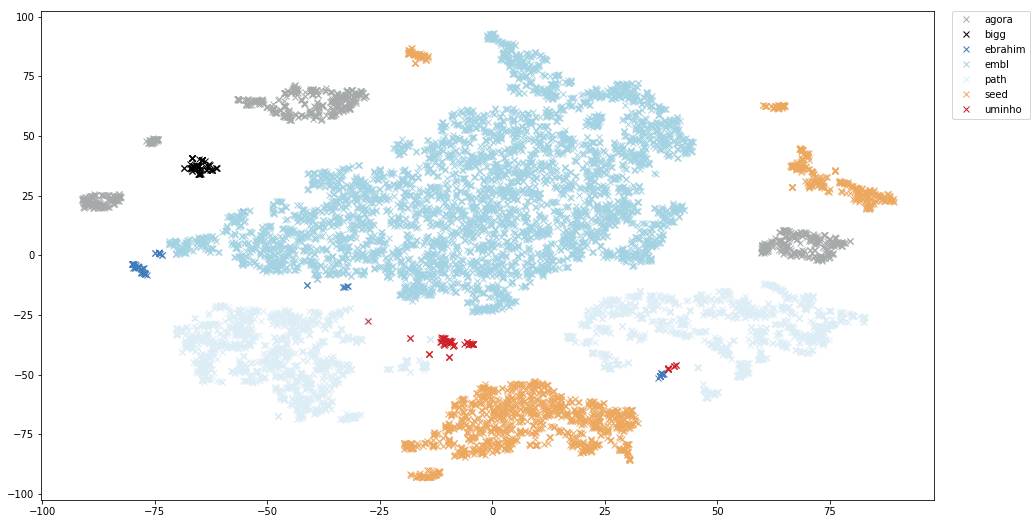

In [27]:
for label, color in zip(clean.index.get_level_values("collection").unique(), colors):
    mask = clean.index.get_level_values("collection") == label
    plt.plot(tsne[mask, 0], tsne[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()

### UMAP

In [28]:
%%time
umap = UMAP(n_components=2).fit_transform(clean)

/home/moritz/.virtualenvs/memote-meta/lib/python3.6/site-packages/umap/spectral.py:229 UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)


CPU times: user 19 s, sys: 2.34 s, total: 21.4 s
Wall time: 17.7 s


In [29]:
x = []
y = []
lbl = []
for label in clean.index.get_level_values("collection").unique():
    mask = clean.index.get_level_values("collection") == label
    x.extend(umap[mask, 0])
    y.extend(umap[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("../data/metric_umap.csv.gz", index=False)

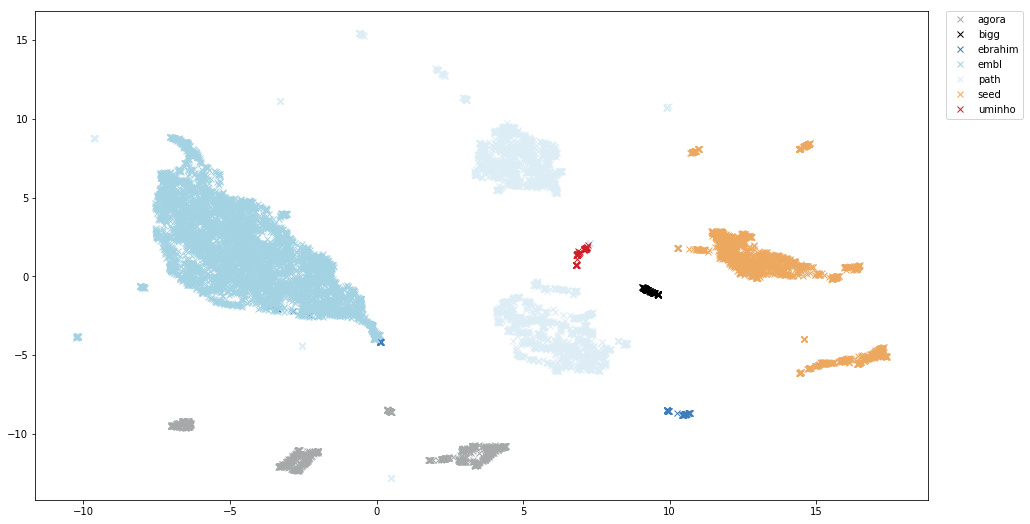

In [30]:
for label, color in zip(clean.index.get_level_values("collection").unique(), colors):
    mask = clean.index.get_level_values("collection") == label
    plt.plot(umap[mask, 0], umap[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()